### Second notebook

This processes the output of weather_munge.ipynb

It selects a sample of rows with relatively consistent data availability and then does munging from 1 row per (location, day) pair to 1 row per location. The location level aggregations include things like "average temp increase per year" from a linear regression.

Then started working on maps.

## TODO

Precipitation graphs and put it on map?

In [1]:
%%capture
!pip install pyarrow
!pip install altair
!pip install vega_datasets

In [2]:
from constants import PERIOD_START, PERIOD_END
from utils import get_major_city_stations, read_stations_data

stations = read_stations_data()
candidate_stations = get_major_city_stations(stations)

In [3]:
import numpy as np
import pandas as pd
from time import time

url = f"s3://weather-bucket/weather_munge_output/weather_{PERIOD_START}_to_{PERIOD_END}.parquet"

df = pd.read_parquet(url)
df['date'] = pd.to_datetime(df.date)
df['year'] = df.date.dt.year
df['month'] = df.date.dt.month

### Calc aggregate stats

In [4]:
sample=df  # Used to have a sampling step. Can clean this up and just use df everywhere instead of sample

sample_means = sample.fillna(0).groupby(['station_id', 'year']).agg(
                        {'max_temp_c': ['min', 'mean', 'max'],
                         'min_temp_c': ['min', 'mean', 'max'],
                         'precip_mm': ['max', 'sum']}
).reset_index()

missing_precip_freq = sample.precip_mm.isnull().groupby(sample['station_id']).mean()
missing_precip_freq.describe()

count    194.000000
mean       0.004766
std        0.025022
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000267
max        0.245189
Name: precip_mm, dtype: float64

In [16]:
from sklearn.linear_model import LinearRegression

def calc_station_stats(station):
    data = sample_means.loc[sample_means.station_id == station, :]
    
    years_zero_reported_precip = (data.precip_mm['sum']==0).sum()
    
    max_model = LinearRegression().fit(X=data.year.values.reshape(-1, 1),
                                       y=data.max_temp_c['mean'])
    min_model = LinearRegression().fit(X=data.year.values.reshape(-1, 1),
                                       y=data.min_temp_c['mean'])

    precip_model = LinearRegression().fit(X=data.year.values.reshape(-1, 1),
                                          y=data.precip_mm['sum'])
 
    summary = {'station_id': station,
               'slope_max_temp': max_model.coef_[0],
               'slope_min_temp': min_model.coef_[0],
               'slope_total_precip_pct': precip_model.coef_[0] / data.precip_mm['sum'].mean(),
               'missing_precip_freq': missing_precip_freq[station],
               'years_zero_reported_precip': years_zero_reported_precip
          }
    return summary


station_summaries = [calc_station_stats(station) for station in sample_means.station_id.unique()]

station_data = pd.DataFrame(
    station_summaries
).merge(
    candidate_stations
).rename(
    columns={'latitude_deg': 'lat', 'longitude_deg': 'lon'}
)
station_data.describe()

,slope_max_temp,slope_min_temp,slope_total_precip_pct,missing_precip_freq,years_zero_reported_precip,lat,lon,elevation
count,216.000000,216.000000,216.000000,216.000000,216.000000,216.000000,216.000000,216.000000
mean,0.032646,0.034460,0.000489,0.004823,0.097222,38.972222,-56.152778,227.314815
std,0.020069,0.021978,0.004873,0.024944,0.737558,14.334839,61.484048,317.135761
min,-0.025424,-0.024769,-0.014759,0.000000,0.000000,-38.000000,-158.000000,1.000000
25%,0.022053,0.022927,-0.002628,0.000000,0.000000,34.000000,-94.000000,22.000000
50%,0.030376,0.035034,0.000775,0.000000,0.000000,39.000000,-82.000000,131.500000
75%,0.042405,0.046946,0.003697,0.000200,0.000000,45.250000,5.000000,292.250000
max,0.085353,0.114796,0.015345,0.245189,9.000000,70.000000,153.000000,1884.000000


In [10]:
# NOTE: We're underrepresenting southern hemisphere
print((station_data.lat<0).mean())
print((stations.lat<0).mean())

0.023148148148148147
0.2138287816899031


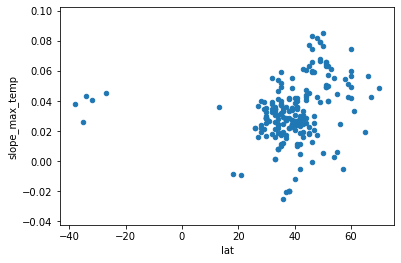

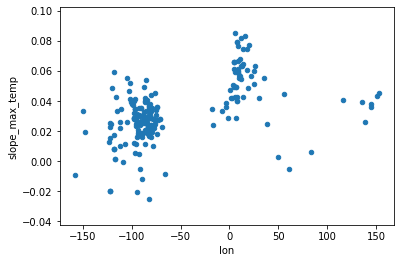

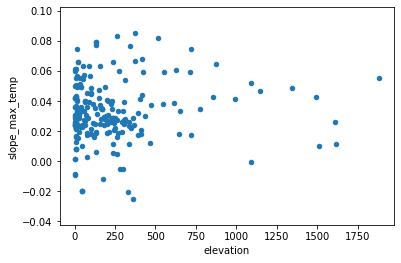

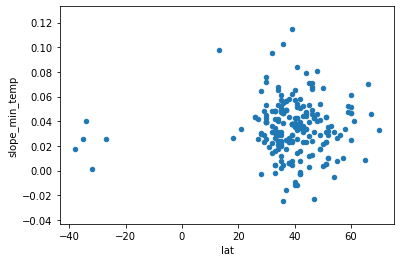

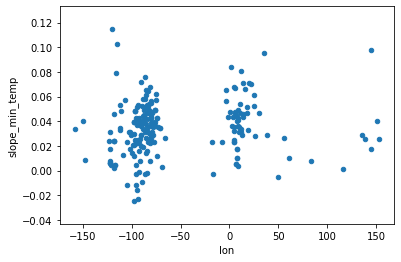

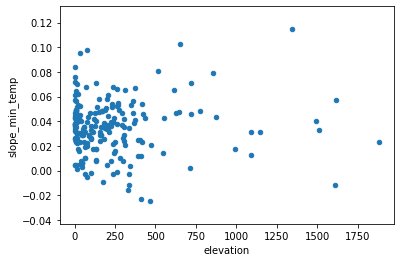

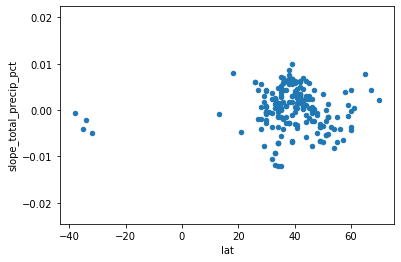

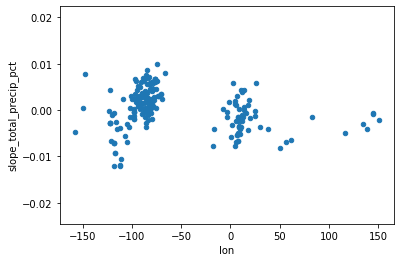

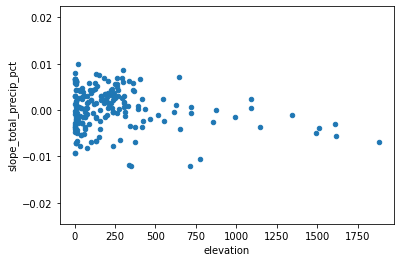

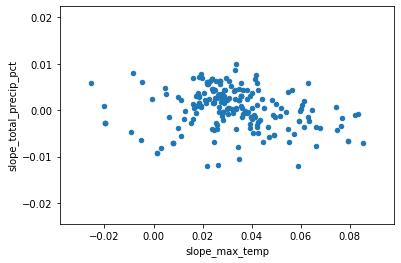

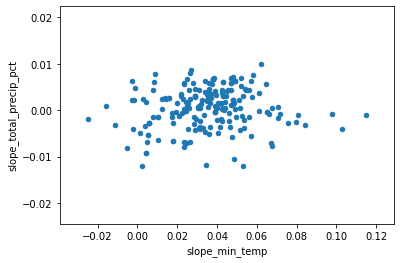

In [11]:
from matplotlib import pyplot as plt

station_data.plot.scatter('lat', 'slope_max_temp')
plt.show()
station_data.plot.scatter('lon', 'slope_max_temp')
plt.show()
station_data.plot.scatter('elevation', 'slope_max_temp')
plt.show()
station_data.plot.scatter('lat', 'slope_min_temp')
plt.show()
station_data.plot.scatter('lon', 'slope_min_temp')
plt.show()
station_data.plot.scatter('elevation', 'slope_min_temp')
plt.show()

station_data_reliable_precip = station_data.query('missing_precip_freq < 0.01')
station_data_reliable_precip.plot.scatter('lat', 'slope_total_precip_pct')
plt.show()
station_data_reliable_precip.plot.scatter('lon', 'slope_total_precip_pct')
plt.show()
station_data_reliable_precip.plot.scatter('elevation', 'slope_total_precip_pct')
plt.show()
station_data_reliable_precip.plot.scatter('slope_max_temp', 'slope_total_precip_pct')
plt.show()
station_data_reliable_precip.plot.scatter('slope_min_temp', 'slope_total_precip_pct')
plt.show()

### Look at outliers

In [13]:
station_data_reliable_precip.query('slope_total_precip_pct > .01 or slope_total_precip_pct < -.01')

,station_id,slope_max_temp,slope_min_temp,slope_total_precip_pct,missing_precip_freq,years_zero_reported_precip,municipality,lat,lon,region,sub-region,country,elevation
71,USC00029634,0.021871,0.053045,-0.012102,0.000886,0,Glendale,34.0,-112.0,Americas,Northern America,United States of America,346.0
93,USW00003159,0.058996,0.002376,-0.011966,0.000135,0,Edwards,35.0,-118.0,Americas,Northern America,United States of America,713.0
184,USW00023160,0.034976,0.048289,-0.010464,0.000000,0,Tucson,32.0,-111.0,Americas,Northern America,United States of America,777.0
186,USW00023183,0.026151,0.034496,-0.011798,0.000000,0,Phoenix,33.0,-112.0,Americas,Northern America,United States of America,337.0


### First Maps

In [15]:
import altair as alt
from vega_datasets import data as vega_data

states = alt.topo_feature(vega_data.us_10m.url, feature='states')

background = alt.Chart(states).mark_geoshape(
    fill='lightgray',
    stroke='white'
).project('albersUsa').properties(
    width=500,
    height=300
)

points = alt.Chart(station_data).mark_circle(opacity=1).encode(
    longitude='lon:Q',
    latitude='lat:Q',
    size=alt.value(30),
    tooltip=['municipality', 'slope_max_temp', 'slope_min_temp'],
    color=alt.Color('slope_max_temp',
                scale=alt.Scale(scheme='blueorange', domain=(-0.05, 0.05)),
                title='Average Temperature Increase Per Year')
)

background + points

alt.LayerChart(...)

In [20]:
points = alt.Chart(station_data).mark_circle(opacity=1).encode(
    longitude='lon:Q',
    latitude='lat:Q',
    size=alt.value(20),
    tooltip=['municipality', 'slope_max_temp', 'slope_min_temp'],
    color=alt.Color('slope_total_precip_pct',
                scale=alt.Scale(scheme='blueorange', reverse=True, domain=(-0.005, 0.005)),
                title='Average Annual Precip Change')
)

background + points

alt.LayerChart(...)

In [18]:
import altair as alt

# Data generators for the background
sphere = alt.sphere()
graticule = alt.graticule()

source = alt.topo_feature(vega_data.world_110m.url, 'countries')

# Layering and configuring the components
base_map = alt.layer(
    alt.Chart(sphere).mark_geoshape(fill='lightblue'),
    alt.Chart(graticule).mark_geoshape(stroke='white', strokeWidth=0.5),
    alt.Chart(source).mark_geoshape(fill='ForestGreen', stroke='black')
).project(
    'naturalEarth1'
).properties(width=600, height=400).configure_view(stroke=None)

base_map + points

alt.LayerChart(...)

In [22]:
np.random.seed(0)
field_to_plot = 'precip_mm'

charts = []
def line_and_regression_plot(this_station_data, field, place_name):
    line_chart = alt.Chart(to_plot, title=place_name).mark_line().encode(
                                alt.X('year:N'),
                                alt.Y(field, scale=alt.Scale(zero=False)),
                                )
    regression = line_chart.transform_regression('year', field).mark_line(color='red')
    return line_chart + regression


for index, station in station_data.sample(15).iterrows():
    this_station_data = sample[sample.station_id == station.station_id]
    place_name = f"{station.municipality}, {station.country} : {station.station_id}"
    to_plot = this_station_data.groupby(['year']).mean()[field_to_plot].to_frame().reset_index()
    plot = line_and_regression_plot(to_plot, field_to_plot, place_name)
    charts.append(plot)
    
alt.vconcat(*charts)

alt.VConcatChart(...)

In [23]:
import sagemaker

sagemaker.Session().upload_data(bucket='weather-bucket', 
                                path='./explore.ipynb',
                                key_prefix='notebooks')

sagemaker.Session().upload_data(bucket='weather-bucket', 
                                path='./weather_munge.ipynb',
                                key_prefix='notebooks')
                                
station_data.to_csv('station_stats.csv', index=False)
sagemaker.Session().upload_data(bucket='weather-bucket', 
                                path='./station_stats.csv',
                                key_prefix='explore_output')


's3://weather-bucket/explore_output/station_stats.csv'